<a href="https://colab.research.google.com/github/9-coding/ComputerVision_TeamProject/blob/main/ActiveLerning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [48]:
import os
# 각자 환경에서 이 부분만 변경하여 사용하면 됩니다.
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50')
print(os.getcwd())


/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50


In [49]:
!pip install wandb

In [50]:
!wandb login f9fc6c65de4904021a59f4c8c60b90961f6ec1fb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

import wandb
wandb.init(project='activelearning1_doyeon')

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        self.image_folder = os.listdir(f'./datasets/{mode}')

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('./datasets', self.mode, img_path)).convert('RGB')
        img = self.transform(img)
        label = int(img_path.split('_')[-1].split('.')[0])
        return (img, label)



cuda


In [52]:
### Data Augmentation ###
param_dist = {
    'brightness': np.random.uniform(0.5, 0.8),
    'contrast': np.random.uniform(0.0, 1.0),
    'saturation': np.random.uniform(0.5, 0.8),
    'hue': np.random.uniform(0.0, 0.5)
}

color_jitter = transforms.ColorJitter(
    brightness=param_dist['brightness'],
    contrast=param_dist['contrast'],
    saturation=param_dist['saturation'],
    hue=param_dist['hue']
)

def transforms_func(transform):
  return transforms.Compose([
    transforms.Resize((448, 448)),
    transform,
    transforms.ToTensor(),
])

# 회전
ROTATION_DEGREE = 30
transforms_rotation1 = transforms_func(transforms.RandomRotation(degrees=ROTATION_DEGREE))
ROTATION_DEGREE = 60
transforms_rotation2 = transforms_func(transforms.RandomRotation(degrees=ROTATION_DEGREE))

# 수평으로 뒤집기
transforms_horizontal_flip = transforms_func(transforms.RandomHorizontalFlip(p=1.0))

# 색상 변환
transforms_color = transforms_func(color_jitter)

# 줌 (Zoom)
zoom_scale = (0.8, 1.2)
transforms_zoom = transforms_func(transforms.RandomResizedCrop(448, scale=zoom_scale))

transforms_train_with_augmentation = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_valtest = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


transforms_train_combined = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=ROTATION_DEGREE),
        transforms.RandomHorizontalFlip(p=1.0),
        color_jitter,
        # transforms.RandomResizedCrop(448, scale=zoom_scale),
    ]),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [53]:
BATCH_SIZE = 64

train_set_with_augmentation = CUB2011(mode='train', transform=transforms_train_with_augmentation)

train_set_rotation1 = CUB2011(mode='train', transform=transforms_rotation1)
train_set_rotation2 = CUB2011(mode='train', transform=transforms_rotation2)
train_set_horizontal_flip = CUB2011(mode='train', transform=transforms_horizontal_flip)
train_set_color = CUB2011(mode='train', transform=transforms_color)
train_set_zoom = CUB2011(mode='train', transform=transforms_zoom)
train_set_random_combined = CUB2011(mode='train', transform=transforms_train_combined)

# combined_train_set = train_set_with_augmentation+ train_set_rotation+ train_set_horizontal_flip + train_set_color + train_set_zoom
combined_train_set = train_set_with_augmentation + train_set_rotation1 + train_set_rotation2 + train_set_color + train_set_horizontal_flip + train_set_zoom + train_set_random_combined
# combined_train_set = ConcatDataset([train_set_with_augmentation+ train_set_random_combined])

val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

train_loader_with_augmentation = DataLoader(combined_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

### Model / Optimizer ###
EPOCH = 15
lr = 0.01
weight_decay = 1e-4
model_with_augmentation = models.resnet18(pretrained=True)

num_features = model_with_augmentation.fc.in_features

# Adjusting for augmentation
model_with_augmentation.fc = nn.Linear(num_features, 50)
model_with_augmentation = model_with_augmentation.to(DEVICE)
optimizer_with_augmentation = optim.SGD(model_with_augmentation.parameters(), lr=lr, weight_decay=weight_decay)



In [54]:

### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)
        train_loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Train Epoch {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
    return train_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            eval_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        eval_loss /= len(val_loader.dataset)
        eval_accuracy = 100 * correct / len(val_loader.dataset)
        return eval_loss, eval_accuracy



Train Epoch 0 [0/259]	Loss: 4.004134
Train Epoch 0 [10/259]	Loss: 3.879562
Train Epoch 0 [20/259]	Loss: 3.867457
Train Epoch 0 [30/259]	Loss: 3.869536
Train Epoch 0 [40/259]	Loss: 3.729990
Train Epoch 0 [50/259]	Loss: 3.661206
Train Epoch 0 [60/259]	Loss: 3.721751
Train Epoch 0 [70/259]	Loss: 3.647059
Train Epoch 0 [80/259]	Loss: 3.474881
Train Epoch 0 [90/259]	Loss: 3.517033
Train Epoch 0 [100/259]	Loss: 3.383789
Train Epoch 0 [110/259]	Loss: 3.433789
Train Epoch 0 [120/259]	Loss: 3.321184
Train Epoch 0 [130/259]	Loss: 3.180880
Train Epoch 0 [140/259]	Loss: 3.213787
Train Epoch 0 [150/259]	Loss: 3.091058
Train Epoch 0 [160/259]	Loss: 2.974315
Train Epoch 0 [170/259]	Loss: 2.870152
Train Epoch 0 [180/259]	Loss: 2.890817
Train Epoch 0 [190/259]	Loss: 2.776033
Train Epoch 0 [200/259]	Loss: 2.806877
Train Epoch 0 [210/259]	Loss: 2.598262
Train Epoch 0 [220/259]	Loss: 2.533727
Train Epoch 0 [230/259]	Loss: 2.682489
Train Epoch 0 [240/259]	Loss: 2.508202
Train Epoch 0 [250/259]	Loss: 2.3357

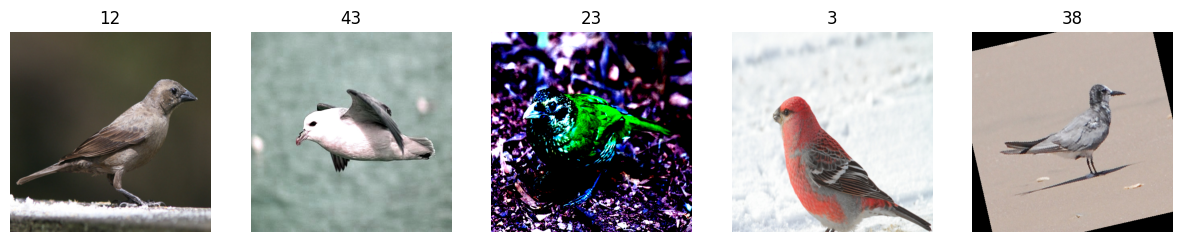

Epoch 0
With Augmentation - Train Loss: 2.3249, Validation Loss: 2.5054, Validation Accuracy: 47.30%
Train Epoch 1 [0/259]	Loss: 2.365974
Train Epoch 1 [10/259]	Loss: 2.193052
Train Epoch 1 [20/259]	Loss: 2.118221
Train Epoch 1 [30/259]	Loss: 2.093580
Train Epoch 1 [40/259]	Loss: 2.191501
Train Epoch 1 [50/259]	Loss: 2.196168
Train Epoch 1 [60/259]	Loss: 1.959995
Train Epoch 1 [70/259]	Loss: 1.825837
Train Epoch 1 [80/259]	Loss: 1.843219
Train Epoch 1 [90/259]	Loss: 2.117511
Train Epoch 1 [100/259]	Loss: 1.927502
Train Epoch 1 [110/259]	Loss: 1.742285
Train Epoch 1 [120/259]	Loss: 1.625512
Train Epoch 1 [130/259]	Loss: 1.669611
Train Epoch 1 [140/259]	Loss: 1.794577
Train Epoch 1 [150/259]	Loss: 1.537559
Train Epoch 1 [160/259]	Loss: 1.622602
Train Epoch 1 [170/259]	Loss: 1.676417
Train Epoch 1 [180/259]	Loss: 1.434472
Train Epoch 1 [190/259]	Loss: 1.574407
Train Epoch 1 [200/259]	Loss: 1.534342
Train Epoch 1 [210/259]	Loss: 1.596170
Train Epoch 1 [220/259]	Loss: 1.284503
Train Epoch 1

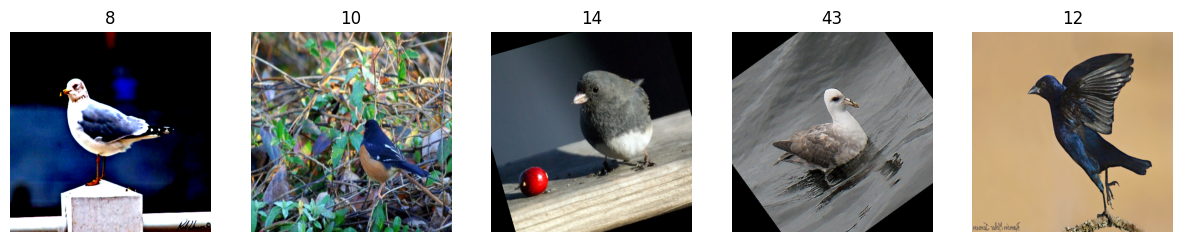

Epoch 1
With Augmentation - Train Loss: 1.9369, Validation Loss: 1.4738, Validation Accuracy: 73.99%
Train Epoch 2 [0/259]	Loss: 1.281616
Train Epoch 2 [10/259]	Loss: 1.240079
Train Epoch 2 [20/259]	Loss: 1.333365
Train Epoch 2 [30/259]	Loss: 1.069653
Train Epoch 2 [40/259]	Loss: 1.365401
Train Epoch 2 [50/259]	Loss: 1.263728
Train Epoch 2 [60/259]	Loss: 1.074059
Train Epoch 2 [70/259]	Loss: 1.136829
Train Epoch 2 [80/259]	Loss: 0.907902
Train Epoch 2 [90/259]	Loss: 1.089594
Train Epoch 2 [100/259]	Loss: 1.040915
Train Epoch 2 [110/259]	Loss: 1.100470
Train Epoch 2 [120/259]	Loss: 0.972452
Train Epoch 2 [130/259]	Loss: 1.087816
Train Epoch 2 [140/259]	Loss: 0.967842
Train Epoch 2 [150/259]	Loss: 0.968686
Train Epoch 2 [160/259]	Loss: 0.976855
Train Epoch 2 [170/259]	Loss: 0.899388
Train Epoch 2 [180/259]	Loss: 0.925562
Train Epoch 2 [190/259]	Loss: 0.848787
Train Epoch 2 [200/259]	Loss: 0.884886
Train Epoch 2 [210/259]	Loss: 0.835916
Train Epoch 2 [220/259]	Loss: 0.918744
Train Epoch 2

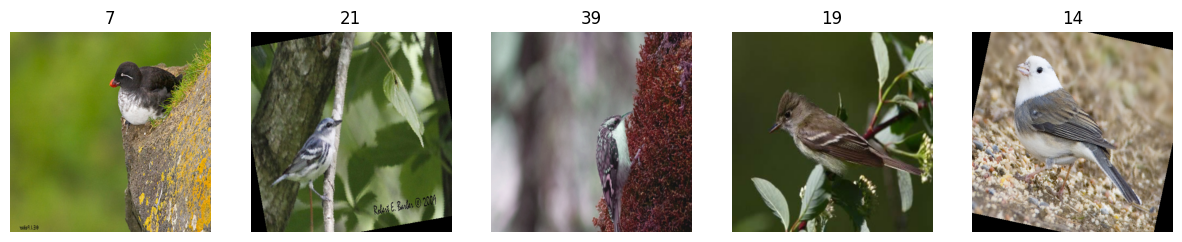

Epoch 2
With Augmentation - Train Loss: 0.7776, Validation Loss: 0.9960, Validation Accuracy: 81.76%
Train Epoch 3 [0/259]	Loss: 0.744411
Train Epoch 3 [10/259]	Loss: 0.812567
Train Epoch 3 [20/259]	Loss: 0.662447
Train Epoch 3 [30/259]	Loss: 0.765859
Train Epoch 3 [40/259]	Loss: 0.596764
Train Epoch 3 [50/259]	Loss: 0.682762
Train Epoch 3 [60/259]	Loss: 0.719105
Train Epoch 3 [70/259]	Loss: 0.684764
Train Epoch 3 [80/259]	Loss: 0.703938
Train Epoch 3 [90/259]	Loss: 0.596246
Train Epoch 3 [100/259]	Loss: 0.786601
Train Epoch 3 [110/259]	Loss: 0.621997
Train Epoch 3 [120/259]	Loss: 0.720335
Train Epoch 3 [130/259]	Loss: 0.737614
Train Epoch 3 [140/259]	Loss: 0.554529
Train Epoch 3 [150/259]	Loss: 0.682926
Train Epoch 3 [160/259]	Loss: 0.600440
Train Epoch 3 [170/259]	Loss: 0.642786
Train Epoch 3 [180/259]	Loss: 0.589240
Train Epoch 3 [190/259]	Loss: 0.496986
Train Epoch 3 [200/259]	Loss: 0.635354
Train Epoch 3 [210/259]	Loss: 0.537143
Train Epoch 3 [220/259]	Loss: 0.522888
Train Epoch 3

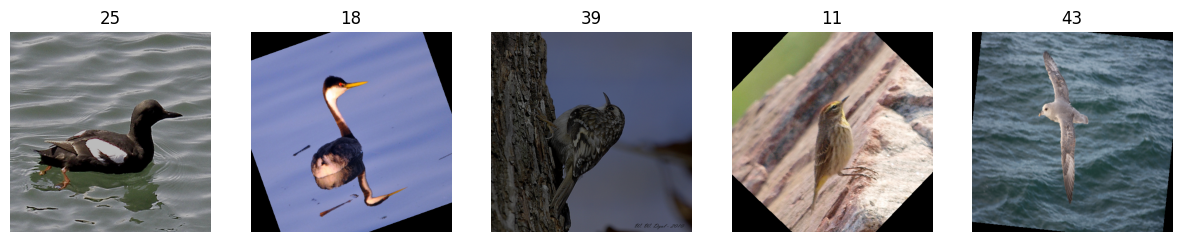

Epoch 3
With Augmentation - Train Loss: 1.6438, Validation Loss: 0.8012, Validation Accuracy: 84.12%
Train Epoch 4 [0/259]	Loss: 0.442596
Train Epoch 4 [10/259]	Loss: 0.492339
Train Epoch 4 [20/259]	Loss: 0.569649
Train Epoch 4 [30/259]	Loss: 0.409579
Train Epoch 4 [40/259]	Loss: 0.437480
Train Epoch 4 [50/259]	Loss: 0.450352
Train Epoch 4 [60/259]	Loss: 0.449361
Train Epoch 4 [70/259]	Loss: 0.519494
Train Epoch 4 [80/259]	Loss: 0.532327
Train Epoch 4 [90/259]	Loss: 0.446705
Train Epoch 4 [100/259]	Loss: 0.440238
Train Epoch 4 [110/259]	Loss: 0.474689
Train Epoch 4 [120/259]	Loss: 0.512055
Train Epoch 4 [130/259]	Loss: 0.417469
Train Epoch 4 [140/259]	Loss: 0.557707
Train Epoch 4 [150/259]	Loss: 0.484223
Train Epoch 4 [160/259]	Loss: 0.370448
Train Epoch 4 [170/259]	Loss: 0.451666
Train Epoch 4 [180/259]	Loss: 0.428733
Train Epoch 4 [190/259]	Loss: 0.386724
Train Epoch 4 [200/259]	Loss: 0.439252
Train Epoch 4 [210/259]	Loss: 0.433574
Train Epoch 4 [220/259]	Loss: 0.375953
Train Epoch 4

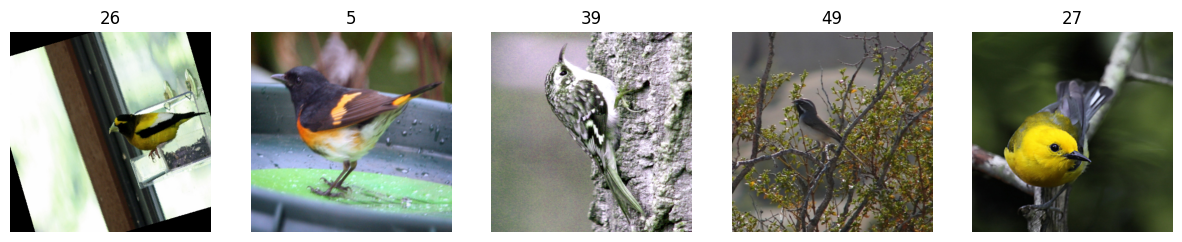

Epoch 4
With Augmentation - Train Loss: 0.6976, Validation Loss: 0.6915, Validation Accuracy: 85.14%
Train Epoch 5 [0/259]	Loss: 0.472132
Train Epoch 5 [10/259]	Loss: 0.400048
Train Epoch 5 [20/259]	Loss: 0.374777
Train Epoch 5 [30/259]	Loss: 0.269524
Train Epoch 5 [40/259]	Loss: 0.308917
Train Epoch 5 [50/259]	Loss: 0.395923
Train Epoch 5 [60/259]	Loss: 0.330814
Train Epoch 5 [70/259]	Loss: 0.370637
Train Epoch 5 [80/259]	Loss: 0.358298
Train Epoch 5 [90/259]	Loss: 0.363926
Train Epoch 5 [100/259]	Loss: 0.363138
Train Epoch 5 [110/259]	Loss: 0.331089
Train Epoch 5 [120/259]	Loss: 0.350964
Train Epoch 5 [130/259]	Loss: 0.351083
Train Epoch 5 [140/259]	Loss: 0.360457
Train Epoch 5 [150/259]	Loss: 0.317659
Train Epoch 5 [160/259]	Loss: 0.342436
Train Epoch 5 [170/259]	Loss: 0.307846
Train Epoch 5 [180/259]	Loss: 0.266163
Train Epoch 5 [190/259]	Loss: 0.320833
Train Epoch 5 [200/259]	Loss: 0.277264
Train Epoch 5 [210/259]	Loss: 0.424459
Train Epoch 5 [220/259]	Loss: 0.359747
Train Epoch 5

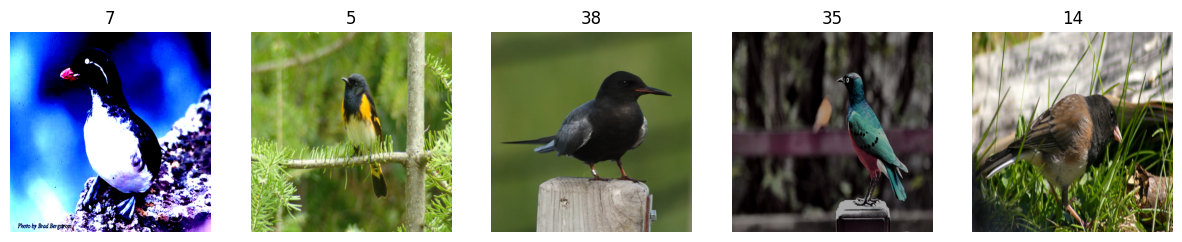

Epoch 5
With Augmentation - Train Loss: 0.8062, Validation Loss: 0.5830, Validation Accuracy: 88.51%
Train Epoch 6 [0/259]	Loss: 0.301737
Train Epoch 6 [10/259]	Loss: 0.343646
Train Epoch 6 [20/259]	Loss: 0.309997
Train Epoch 6 [30/259]	Loss: 0.208848
Train Epoch 6 [40/259]	Loss: 0.221751
Train Epoch 6 [50/259]	Loss: 0.331268
Train Epoch 6 [60/259]	Loss: 0.249960
Train Epoch 6 [70/259]	Loss: 0.344386
Train Epoch 6 [80/259]	Loss: 0.328229
Train Epoch 6 [90/259]	Loss: 0.280908
Train Epoch 6 [100/259]	Loss: 0.248788
Train Epoch 6 [110/259]	Loss: 0.239675
Train Epoch 6 [120/259]	Loss: 0.237378
Train Epoch 6 [130/259]	Loss: 0.274273
Train Epoch 6 [140/259]	Loss: 0.239764
Train Epoch 6 [150/259]	Loss: 0.273533
Train Epoch 6 [160/259]	Loss: 0.306773
Train Epoch 6 [170/259]	Loss: 0.282449
Train Epoch 6 [180/259]	Loss: 0.196691
Train Epoch 6 [190/259]	Loss: 0.189213
Train Epoch 6 [200/259]	Loss: 0.258985
Train Epoch 6 [210/259]	Loss: 0.195687
Train Epoch 6 [220/259]	Loss: 0.263965
Train Epoch 6

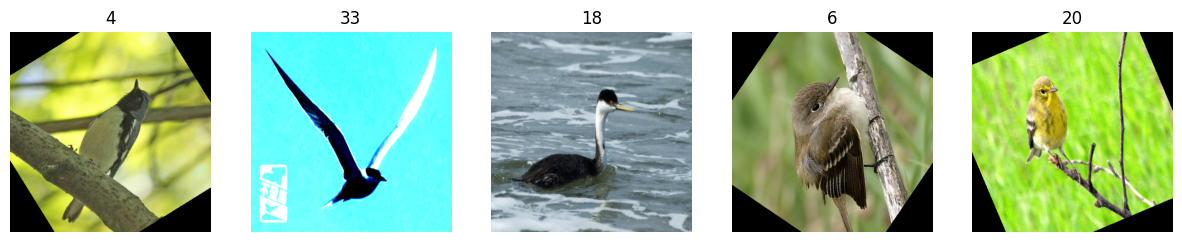

Epoch 6
With Augmentation - Train Loss: 0.3031, Validation Loss: 0.5447, Validation Accuracy: 90.20%
Train Epoch 7 [0/259]	Loss: 0.192807
Train Epoch 7 [10/259]	Loss: 0.213802
Train Epoch 7 [20/259]	Loss: 0.175702
Train Epoch 7 [30/259]	Loss: 0.189542
Train Epoch 7 [40/259]	Loss: 0.248085
Train Epoch 7 [50/259]	Loss: 0.155792
Train Epoch 7 [60/259]	Loss: 0.275336
Train Epoch 7 [70/259]	Loss: 0.258010
Train Epoch 7 [80/259]	Loss: 0.216114
Train Epoch 7 [90/259]	Loss: 0.162755
Train Epoch 7 [100/259]	Loss: 0.231280
Train Epoch 7 [110/259]	Loss: 0.273708
Train Epoch 7 [120/259]	Loss: 0.173189
Train Epoch 7 [130/259]	Loss: 0.198177
Train Epoch 7 [140/259]	Loss: 0.163876
Train Epoch 7 [150/259]	Loss: 0.138650
Train Epoch 7 [160/259]	Loss: 0.151839
Train Epoch 7 [170/259]	Loss: 0.133409
Train Epoch 7 [180/259]	Loss: 0.151773
Train Epoch 7 [190/259]	Loss: 0.215920
Train Epoch 7 [200/259]	Loss: 0.176688
Train Epoch 7 [210/259]	Loss: 0.179423
Train Epoch 7 [220/259]	Loss: 0.171885
Train Epoch 7

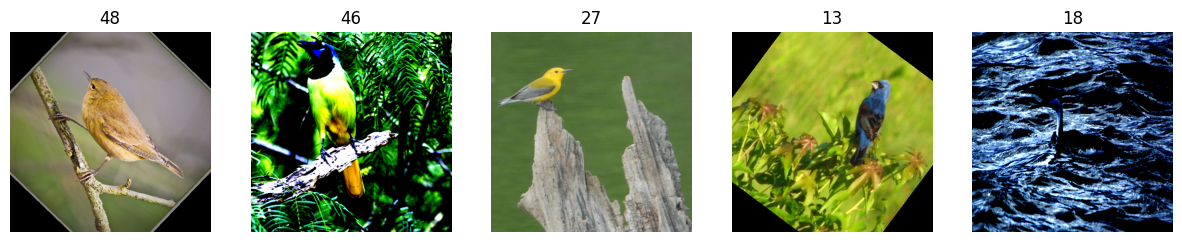

Epoch 7
With Augmentation - Train Loss: 0.2396, Validation Loss: 0.4694, Validation Accuracy: 89.53%
Train Epoch 8 [0/259]	Loss: 0.178573
Train Epoch 8 [10/259]	Loss: 0.165999
Train Epoch 8 [20/259]	Loss: 0.109626
Train Epoch 8 [30/259]	Loss: 0.139201
Train Epoch 8 [40/259]	Loss: 0.187883
Train Epoch 8 [50/259]	Loss: 0.152753
Train Epoch 8 [60/259]	Loss: 0.118241
Train Epoch 8 [70/259]	Loss: 0.216916
Train Epoch 8 [80/259]	Loss: 0.190575
Train Epoch 8 [90/259]	Loss: 0.139672
Train Epoch 8 [100/259]	Loss: 0.159027
Train Epoch 8 [110/259]	Loss: 0.188848
Train Epoch 8 [120/259]	Loss: 0.149933
Train Epoch 8 [130/259]	Loss: 0.125656
Train Epoch 8 [140/259]	Loss: 0.132213
Train Epoch 8 [150/259]	Loss: 0.227247
Train Epoch 8 [160/259]	Loss: 0.130488
Train Epoch 8 [170/259]	Loss: 0.193877
Train Epoch 8 [180/259]	Loss: 0.111441
Train Epoch 8 [190/259]	Loss: 0.139040
Train Epoch 8 [200/259]	Loss: 0.136094
Train Epoch 8 [210/259]	Loss: 0.110269
Train Epoch 8 [220/259]	Loss: 0.162437
Train Epoch 8

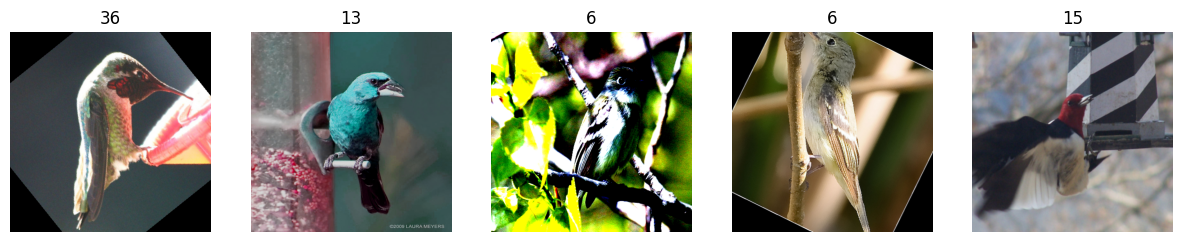

Epoch 8
With Augmentation - Train Loss: 0.7197, Validation Loss: 0.4746, Validation Accuracy: 89.53%
Train Epoch 9 [0/259]	Loss: 0.149396
Train Epoch 9 [10/259]	Loss: 0.131904
Train Epoch 9 [20/259]	Loss: 0.153977
Train Epoch 9 [30/259]	Loss: 0.127248
Train Epoch 9 [40/259]	Loss: 0.114487
Train Epoch 9 [50/259]	Loss: 0.144474
Train Epoch 9 [60/259]	Loss: 0.125996
Train Epoch 9 [70/259]	Loss: 0.136626
Train Epoch 9 [80/259]	Loss: 0.189254
Train Epoch 9 [90/259]	Loss: 0.184109
Train Epoch 9 [100/259]	Loss: 0.107340
Train Epoch 9 [110/259]	Loss: 0.117122
Train Epoch 9 [120/259]	Loss: 0.131616
Train Epoch 9 [130/259]	Loss: 0.133667
Train Epoch 9 [140/259]	Loss: 0.102555
Train Epoch 9 [150/259]	Loss: 0.140836
Train Epoch 9 [160/259]	Loss: 0.097584
Train Epoch 9 [170/259]	Loss: 0.105355
Train Epoch 9 [180/259]	Loss: 0.118993
Train Epoch 9 [190/259]	Loss: 0.094890
Train Epoch 9 [200/259]	Loss: 0.088401
Train Epoch 9 [210/259]	Loss: 0.145751
Train Epoch 9 [220/259]	Loss: 0.114607
Train Epoch 9

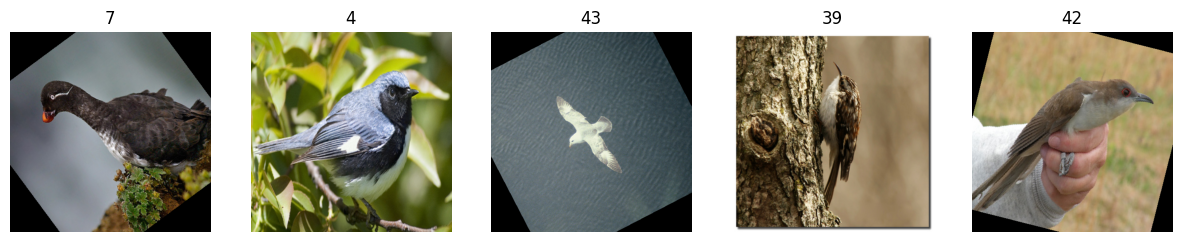

Epoch 9
With Augmentation - Train Loss: 0.4801, Validation Loss: 0.4348, Validation Accuracy: 90.20%
Train Epoch 10 [0/259]	Loss: 0.140991
Train Epoch 10 [10/259]	Loss: 0.100262
Train Epoch 10 [20/259]	Loss: 0.126669
Train Epoch 10 [30/259]	Loss: 0.084771
Train Epoch 10 [40/259]	Loss: 0.136704
Train Epoch 10 [50/259]	Loss: 0.117719
Train Epoch 10 [60/259]	Loss: 0.091717
Train Epoch 10 [70/259]	Loss: 0.104526
Train Epoch 10 [80/259]	Loss: 0.116471
Train Epoch 10 [90/259]	Loss: 0.092545
Train Epoch 10 [100/259]	Loss: 0.133972
Train Epoch 10 [110/259]	Loss: 0.071911
Train Epoch 10 [120/259]	Loss: 0.079284
Train Epoch 10 [130/259]	Loss: 0.093674
Train Epoch 10 [140/259]	Loss: 0.084856
Train Epoch 10 [150/259]	Loss: 0.105975
Train Epoch 10 [160/259]	Loss: 0.158590
Train Epoch 10 [170/259]	Loss: 0.117015
Train Epoch 10 [180/259]	Loss: 0.087315
Train Epoch 10 [190/259]	Loss: 0.076142
Train Epoch 10 [200/259]	Loss: 0.107675
Train Epoch 10 [210/259]	Loss: 0.078096
Train Epoch 10 [220/259]	Loss:

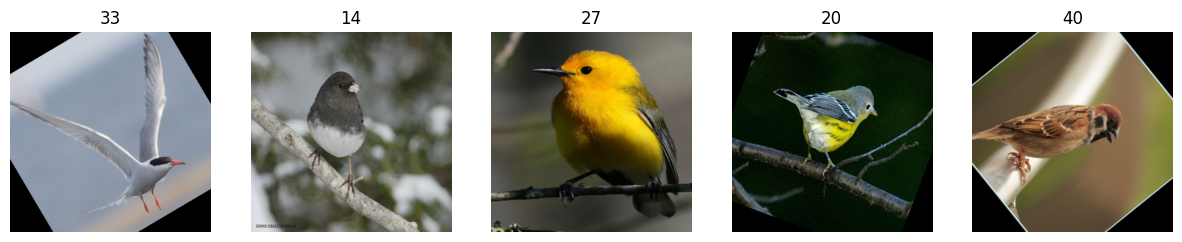

Epoch 10
With Augmentation - Train Loss: 0.2401, Validation Loss: 0.4305, Validation Accuracy: 89.19%
Train Epoch 11 [0/259]	Loss: 0.112814
Train Epoch 11 [10/259]	Loss: 0.115662
Train Epoch 11 [20/259]	Loss: 0.107250
Train Epoch 11 [30/259]	Loss: 0.101142
Train Epoch 11 [40/259]	Loss: 0.097773
Train Epoch 11 [50/259]	Loss: 0.071528
Train Epoch 11 [60/259]	Loss: 0.071492
Train Epoch 11 [70/259]	Loss: 0.055759
Train Epoch 11 [80/259]	Loss: 0.062093
Train Epoch 11 [90/259]	Loss: 0.061425
Train Epoch 11 [100/259]	Loss: 0.088882
Train Epoch 11 [110/259]	Loss: 0.172019
Train Epoch 11 [120/259]	Loss: 0.069985
Train Epoch 11 [130/259]	Loss: 0.071620
Train Epoch 11 [140/259]	Loss: 0.070138
Train Epoch 11 [150/259]	Loss: 0.080480
Train Epoch 11 [160/259]	Loss: 0.066231
Train Epoch 11 [170/259]	Loss: 0.067289
Train Epoch 11 [180/259]	Loss: 0.074105
Train Epoch 11 [190/259]	Loss: 0.111348
Train Epoch 11 [200/259]	Loss: 0.053392
Train Epoch 11 [210/259]	Loss: 0.106661
Train Epoch 11 [220/259]	Loss

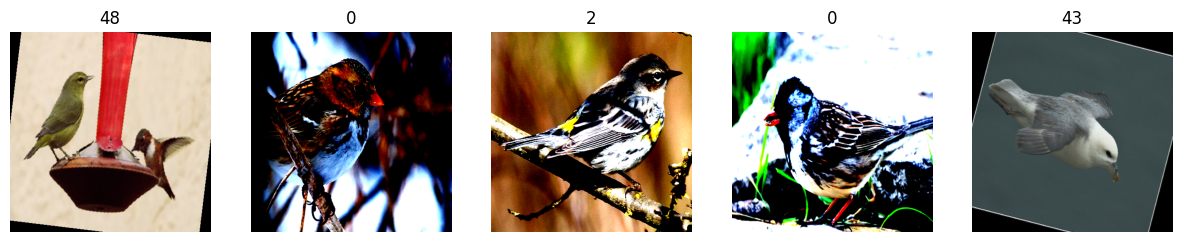

Epoch 11
With Augmentation - Train Loss: 0.4635, Validation Loss: 0.4245, Validation Accuracy: 89.86%
Train Epoch 12 [0/259]	Loss: 0.064557
Train Epoch 12 [10/259]	Loss: 0.076007
Train Epoch 12 [20/259]	Loss: 0.066859
Train Epoch 12 [30/259]	Loss: 0.094197
Train Epoch 12 [40/259]	Loss: 0.077796
Train Epoch 12 [50/259]	Loss: 0.065887
Train Epoch 12 [60/259]	Loss: 0.064228
Train Epoch 12 [70/259]	Loss: 0.172953
Train Epoch 12 [80/259]	Loss: 0.053101
Train Epoch 12 [90/259]	Loss: 0.057005
Train Epoch 12 [100/259]	Loss: 0.081848
Train Epoch 12 [110/259]	Loss: 0.078301
Train Epoch 12 [120/259]	Loss: 0.067891
Train Epoch 12 [130/259]	Loss: 0.103021
Train Epoch 12 [140/259]	Loss: 0.062344
Train Epoch 12 [150/259]	Loss: 0.088989
Train Epoch 12 [160/259]	Loss: 0.060187
Train Epoch 12 [170/259]	Loss: 0.087023
Train Epoch 12 [180/259]	Loss: 0.069268
Train Epoch 12 [190/259]	Loss: 0.053800
Train Epoch 12 [200/259]	Loss: 0.048580
Train Epoch 12 [210/259]	Loss: 0.055013
Train Epoch 12 [220/259]	Loss

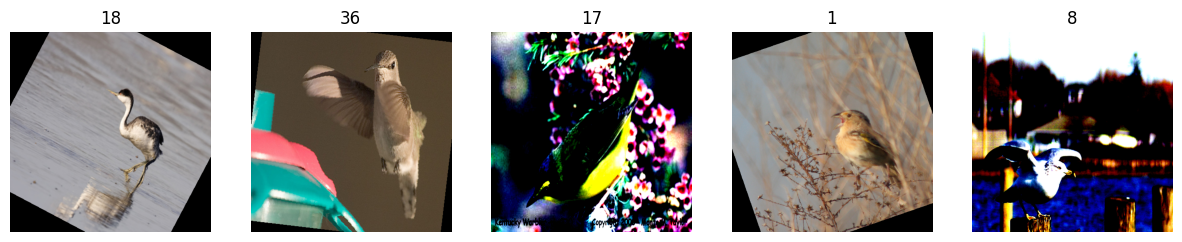

Epoch 12
With Augmentation - Train Loss: 0.2227, Validation Loss: 0.4167, Validation Accuracy: 90.88%
Train Epoch 13 [0/259]	Loss: 0.058296
Train Epoch 13 [10/259]	Loss: 0.093366
Train Epoch 13 [20/259]	Loss: 0.045493
Train Epoch 13 [30/259]	Loss: 0.059541
Train Epoch 13 [40/259]	Loss: 0.049617
Train Epoch 13 [50/259]	Loss: 0.036270
Train Epoch 13 [60/259]	Loss: 0.046370
Train Epoch 13 [70/259]	Loss: 0.120491
Train Epoch 13 [80/259]	Loss: 0.066944
Train Epoch 13 [90/259]	Loss: 0.147288
Train Epoch 13 [100/259]	Loss: 0.062758
Train Epoch 13 [110/259]	Loss: 0.070772
Train Epoch 13 [120/259]	Loss: 0.084880
Train Epoch 13 [130/259]	Loss: 0.046307
Train Epoch 13 [140/259]	Loss: 0.044700
Train Epoch 13 [150/259]	Loss: 0.043591
Train Epoch 13 [160/259]	Loss: 0.075392
Train Epoch 13 [170/259]	Loss: 0.056771
Train Epoch 13 [180/259]	Loss: 0.063966
Train Epoch 13 [190/259]	Loss: 0.045774
Train Epoch 13 [200/259]	Loss: 0.055276
Train Epoch 13 [210/259]	Loss: 0.065822
Train Epoch 13 [220/259]	Loss

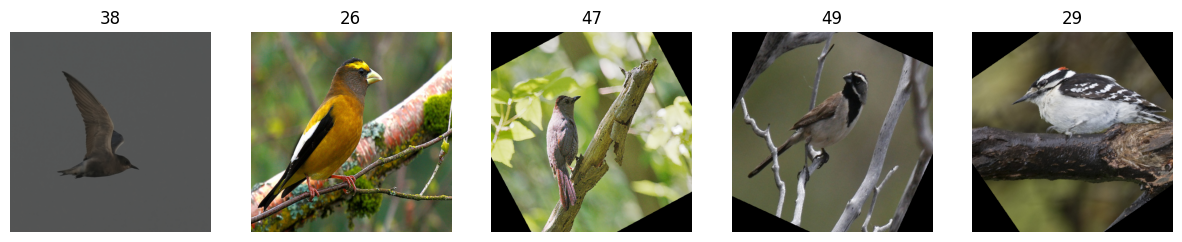

Epoch 13
With Augmentation - Train Loss: 0.2580, Validation Loss: 0.4058, Validation Accuracy: 90.20%
Train Epoch 14 [0/259]	Loss: 0.067946
Train Epoch 14 [10/259]	Loss: 0.067864
Train Epoch 14 [20/259]	Loss: 0.033339
Train Epoch 14 [30/259]	Loss: 0.065767
Train Epoch 14 [40/259]	Loss: 0.065285
Train Epoch 14 [50/259]	Loss: 0.045763
Train Epoch 14 [60/259]	Loss: 0.071911
Train Epoch 14 [70/259]	Loss: 0.063933
Train Epoch 14 [80/259]	Loss: 0.045572
Train Epoch 14 [90/259]	Loss: 0.061953
Train Epoch 14 [100/259]	Loss: 0.068220
Train Epoch 14 [110/259]	Loss: 0.067013
Train Epoch 14 [120/259]	Loss: 0.060810
Train Epoch 14 [130/259]	Loss: 0.067796
Train Epoch 14 [140/259]	Loss: 0.047454
Train Epoch 14 [150/259]	Loss: 0.054542
Train Epoch 14 [160/259]	Loss: 0.064690
Train Epoch 14 [170/259]	Loss: 0.041496
Train Epoch 14 [180/259]	Loss: 0.049500
Train Epoch 14 [190/259]	Loss: 0.064153
Train Epoch 14 [200/259]	Loss: 0.065011
Train Epoch 14 [210/259]	Loss: 0.047342
Train Epoch 14 [220/259]	Loss

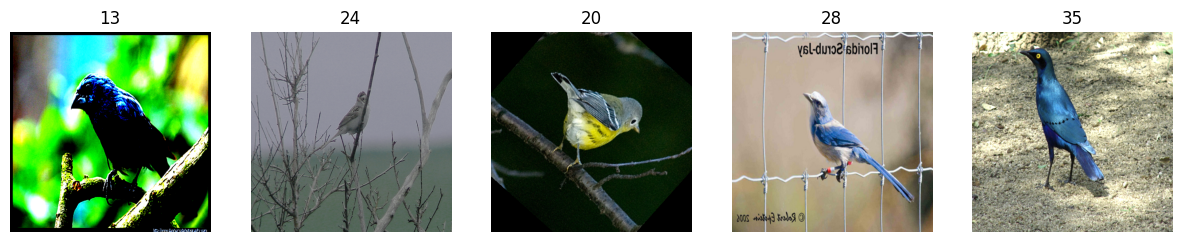

Epoch 14
With Augmentation - Train Loss: 0.1395, Validation Loss: 0.3766, Validation Accuracy: 89.86%
[FINAL with Augmentation] Test Loss: 0.4075, Accuracy: 91.2752%
Best Accuracy with Augmentation: 90.88%
Elapsed Time: 1h, 13m, 26s
time: 1h, 73m, 26s


In [55]:
### Main ###
start = time.time()
best_with_augmentation = 0
best_without_augmentation = 0

wandb.log({
        'lr': lr,
        'BATCH_SIZE': BATCH_SIZE,
        'weight_decay': weight_decay,
})

for epoch in range(EPOCH):
    # With Augmentation
    train_loss_with_augmentation = train(model_with_augmentation, train_loader_with_augmentation, optimizer_with_augmentation, epoch)
    val_loss_with_augmentation, val_accuracy_with_augmentation = evaluate(model_with_augmentation, val_loader)

    # Logging for model with augmentation
    wandb.log({
        'train_loss_with_augmentation': train_loss_with_augmentation.item(),
        'val_loss_with_augmentation': val_loss_with_augmentation,
        'val_accuracy_with_augmentation': val_accuracy_with_augmentation,
    })

    # Save best model
    if val_accuracy_with_augmentation > best_with_augmentation:
        best_with_augmentation = val_accuracy_with_augmentation
        torch.save(model_with_augmentation.state_dict(), "./best_model_with_augmentation.pth")

    # augmentation 적용한 이미지 보기
    dataiter = iter(train_loader_with_augmentation)
    images, labels = dataiter.__next__()
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
      image = images[i].numpy().transpose((1, 2, 0))
      image = np.clip(image, 0, 1)
      axes[i].imshow(image)
      axes[i].set_title(labels[i].item())
      axes[i].axis('off')
    plt.show()

    print(f'Epoch {epoch}')
    print(f"With Augmentation - Train Loss: {train_loss_with_augmentation.item():.4f}, Validation Loss: {val_loss_with_augmentation:.4f}, Validation Accuracy: {val_accuracy_with_augmentation:.2f}%")

# Test results
test_loss_with_augmentation, test_accuracy_with_augmentation = evaluate(model_with_augmentation, test_loader)

wandb.log({'test_accuracy': test_accuracy_with_augmentation})

print(f'[FINAL with Augmentation] Test Loss: {test_loss_with_augmentation:.4f}, Accuracy: {test_accuracy_with_augmentation:.4f}%')

end = time.time()
elasped_time = end - start
print(f"Best Accuracy with Augmentation: {best_with_augmentation:.2f}%")
print(f"Elapsed Time: {int(elasped_time/3600)}h, {int((elasped_time%3600)/60)}m, {int(elasped_time%60)}s")
print(f"time: {int (elasped_time/3600)}h, {int((elasped_time%3600)/60)}m, {int(elasped_time%60)}s")